<a href="https://colab.research.google.com/github/asdafsafas/inf2008_labs/blob/main/INF2008_Lab03_2401892_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lab 03: Data Preparation for Modeling (Classification)

**CRISP-DM Focus: Data Preparation (DP) + Modeling + Evaluation**

In this lab, **modeling is used only as a measurement tool**. We will do a simple short model iteration to get us used to the entire Machine Learning cycle. We will also **not** hypertune models. We will carry out feature engineering (data preparation step), run a simple decision tree model and evaluate the accuracy to test if that improvement mattered.

Dataset: Titanic (Kaggle)  
Target: `Survived` (0 / 1)

---



## Learning Outcomes

By the end of this lab, you should be able to:
1. Apply a **structured data preparation workflow** aligned to CRISP-DM.
2. Distinguish clearly between **Data Understanding**, **Data Preparation**, and **Modeling**.
3. Prepare data safely for a **Decision Tree classifier**.
4. Explain why a preparation decision changes (or does not change) model performance.
5. Identify where data leakage could occur.



## The Role of Modeling in This Lab

In CRISP-DM, Modeling and Evaluation are full phases.

In this lab, we will not cover them in full because we are using them to guide us to answer the question:

> **Did our Data Preparation decisions make the data more learnable?**

Therefore we will:
- use **one simple model** (Decision Tree)
- use **one metric** (accuracy + confusion matrix)
- avoid tuning, optimisation, and model comparison (these will be covered in subsequent labs)

## 0. Environment Setup

In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
RANDOM_STATE = 42




---

> Why do we set RANDOM_STATE = 42?
>
> Many steps in machine learning involve randomness, even when the code looks deterministic. Eg if there is a tie in a decision tree split.
>
> If we do not control randomness, then two students running the same notebook with the same code on the same dataset can get different accuracy values.
>
> Hence setting the random state ensures reproducibility in:
>* the same train/test split
>* the same random decisions inside the model
>* the same results when nothing else changes
>
> If randomness changes between runs, the accuracy may go up or down even if data preparation did not change and students may draw incorrect conclusions
>
>
> By fixing RANDOM_STATE, we make sure that the only thing that changes is the data preparation step and this makes the modeling loop reproducible.

---




## 1. Dataset Loading and Scope

Place Kaggle's `train.csv` in the same directory as this notebook.


In [ ]:

if not os.path.exists("train.csv"):
    raise FileNotFoundError("Please place Kaggle Titanic train.csv in the same folder as this notebook.")

df = pd.read_csv("train.csv")
print("shape:", df.shape)
df.head()


shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



## 2. Data Understanding Checkpoint (DU)

Recall  in Lab 01, one of the key items here is explictly showing the datatype of each variable, and also finding out missing values, possible leakages etc.

You can get the columns for the following:

In [ ]:
df.dtypes

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


In [ ]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### Exercise DU-1

Please fill up the following table:


| column_name  | role        | type       |
|--------------|-------------|------------|
| PassengerId  |  |    |
| Survived     |  |    |
| Pclass       |  |    |
| Name         |  |    |
| Sex          |  |    |
| Age          |  |    |
| SibSp        |  |    |
| Parch        |  |    |
| Ticket       |  |    |
| Fare         |  |    |
| Cabin        |  |    |
| Embarked     |  |    |


In [ ]:
list(df.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

### Exercise DU-2

Check the missing values per column.

,nunique,missing
PassengerId,891,0
Name,891,0
Ticket,681,0
Fare,248,0
Cabin,148,687
Age,89,177
SibSp,7,0
Parch,7,0
Embarked,4,2
Pclass,3,0


### Exercise DU-3

Plot the target distribution for `Survived`.

,count
Survived,
0,549
1,342


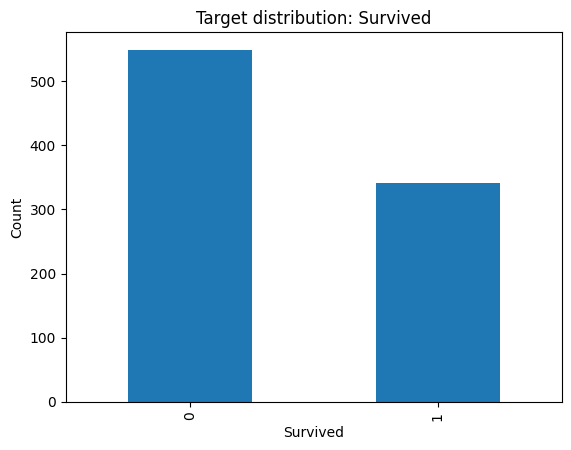


**Suggested observations (example):**
- Some important columns have missing values (commonly `Age`, `Cabin`, sometimes `Embarked`).
- Several columns are categorical strings and will require encoding.
- Some columns are identifiers/text-heavy and should be excluded in DP1 to keep the lab focused.



## Data Preparation Framework (DP Stages)

We follow five stages:

- **DP1 – Select**: choose what features are allowed (remove IDs/leakage/noise)
- **DP2 – Clean**: handle missing/invalid values
- **DP3 – Structure**: encode categoricals; ensure numeric inputs
- **DP4 – Construct**: You are allowed to rearrange information you already have, but you are not allowed to create new information.
- **DP5 – Validate**: split correctly; fit preprocessing on train only

DP4 is intentionally narrow (to avoid confusion)
In this lab, you may combine or simplify existing columns
if the result still clearly represents the same real-world idea. You should not create features that only make sense because of the model. For instance:
1. **No new information** (only recombine existing columns)
2. **Human-interpretable meaning** (explainable without referencing a model)
3. **Model-agnostic** (should make sense before choosing the model)

For example:
*   `FamilySize = SibSp + Parch + 1`

Note:
*   SibSp  = family members (siblings/spouse)
*   Parch  = family members (parents/children)
*   1    = the passenger themselves


## 3. DP1 – Select (Feature Scoping)

We will use a compact, interpretable feature set.

**Keep:**
- Numerical: `Age`, `Fare`, `SibSp`, `Parch`
- Categorical: `Sex`, `Pclass`, `Embarked`

**Drop initially:**
`PassengerId`, `Name`, `Ticket`, `Cabin`.

### Exercise DP-1.1

Create `X` and `y` using only the selected columns.


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S



## 4. Modelling & Evaluation Loop (Baseline)

Here we use a simple model early only to measure the effect of data preparation not to perform modelling. This is very important!

This is a baseline with:
- Train/test split
- Simple imputation + one-hot encoding
- Decision Tree (depth limited for interpretability)

### Exercise DP-1.2

Build a pipeline that:
- imputes numeric with median
- imputes categorical with most frequent
- one-hot encodes categoricals
- trains a decision tree (`max_depth=3`)

Report:
- accuracy
- confusion matrix

It is important that no additional feature engineering work should be done here. The purpose here is to get an accuracy floor.

Baseline accuracy: 0.7848


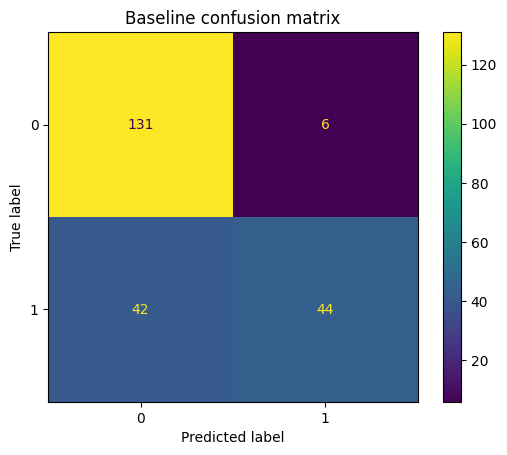

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       137
           1       0.88      0.51      0.65        86

    accuracy                           0.78       223
   macro avg       0.82      0.73      0.75       223
weighted avg       0.80      0.78      0.77       223




## 5. DP2 – Clean

The above code inputed values quite randomly to build the baseline accuracy floor.

In this stage we want to be more explicit and decide:
* Should missing values be filled or dropped?
* If filled, how? Mean, median, mode?
* Does missing values itself carry meaning?

These decisions are made once and documented.

,nunique,missing_count,missing_pct
Cabin,148,687,77.1
Age,89,177,19.9
Embarked,4,2,0.2
PassengerId,891,0,0.0
Name,891,0,0.0
Pclass,3,0,0.0
Survived,2,0,0.0
Sex,2,0,0.0
Parch,7,0,0.0
SibSp,7,0,0.0


This calculates the missing values. But it does ignore empty cells, or cells with blanks / spaces. Lets try to include them in as well.

,nunique,na_count,na_pct,blank_count,effective_missing_count,effective_missing_pct
Cabin,148,687,77.1,0,687,77.1
Age,89,177,19.9,0,177,19.9
Embarked,4,2,0.2,0,2,0.2
PassengerId,891,0,0.0,0,0,0.0
Name,891,0,0.0,0,0,0.0
Pclass,3,0,0.0,0,0,0.0
Survived,2,0,0.0,0,0,0.0
Sex,2,0,0.0,0,0,0.0
Parch,7,0,0.0,0,0,0.0
SibSp,7,0,0.0,0,0,0.0


Lets check the age column.

In [ ]:
df["Age"].describe()

,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000


<Axes: >

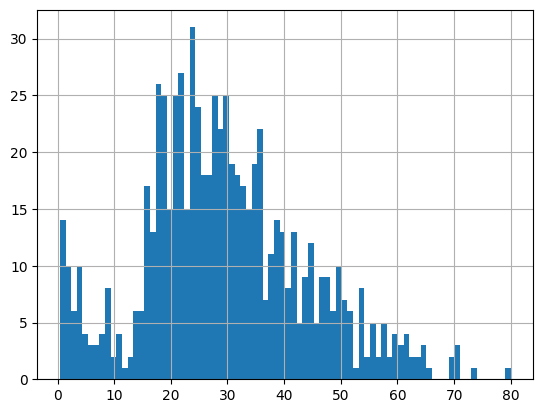

In [ ]:
df["Age"].hist(bins=80)

Age: impute using median, because age has a skewed distribution and median is robust to outliers.

Embarked: impute using most frequent category, because NA is rare and categorical.


## 6. DP3 – Structure (Categoricals -> Numbers)

DP3 is about considering and narrowing options, not executing or finalising them. Hence at this stage you should:
* identify which variables are categorical
* inspect their values
* consider possible encoding options

### Exercise DP-3

Using the features selected in DP1, carry out the following four steps:

* Step 1: Recall features selected in DP1
* Step 2: Classify features as numeric vs categorical
* Step 3: Inspect the categorical variables (find out how many of each class is in the variable)
* Step 4: Conclude what kind of variables they are
* Step 5: what encoding options are appropriate





#### Step 1: Recall features selected in DP1

From DP1, the selected features are:

> Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

#### Step 2: Classify features as numeric vs categorical

Numeric features
* Age: continuous numeric
* Fare: continuous numeric
* SibSp: discrete numeric (count)
* Parch: discrete numeric (count)

Categorical features
* Sex: categorical (nominal)
* Embarked: categorical (nominal)
* Pclass: categorical (ordinal, even though stored as integers)

Important note:
Pclass is numeric in storage (int), but categorical in meaning.

#### Step 3: Inspect the categorical variables



Value counts for Sex:
Sex
male      434
female    234
Name: count, dtype: int64

Value counts for Embarked:
Embarked
S      479
C      133
Q       54
NaN      2
Name: count, dtype: int64

Value counts for Pclass:
Pclass
3    368
1    159
2    141
Name: count, dtype: int64


#### Step 4: Conclude what kind of variables they are

**Sex**
* Two categories: male, female
* No ordering
* No rare categories

Conclusion: nominal categorical variable.

**Embarked**
* Three categories: S, C, Q
* Some categories are much less frequent
* May contain missing values

Conclusion: nominal categorical variable with rare values.

**Pclass**
* Values: 1, 2, 3
* Clear ordering (1st > 2nd > 3rd class)

Conclusion: ordinal categorical variable.

#### Step 5: what encoding options are appropriate

**Sex**
Sex is a nominal categorical variable (no natural ordering).

Therefore, encodings that impose an artificial order (e.g. label encoding) are inappropriate.

Suitable options include one-hot encoding.

**Embarked**

Embarked is a nominal categorical variable with a small number of categories.

Suitable options include one-hot encoding.

**Pclass**

Pclass is an ordinal categorical variable (1st < 2nd < 3rd class).

Suitable options include ordinal encoding or one-hot encoding.


## 7. DP4 – Construct

We will engineer only these two features here:

- `FamilySize = SibSp + Parch + 1`
- `IsAlone = (FamilySize == 1)`

### Exercise DP-4

Create `X_fe` with the two new features.  
Then re-run the **same modelling & evaluation loop** (same model depth, same split seed).
Compare accuracy against baseline.


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,3,male,22.0,1,0,7.2500,S,2,0
1,1,female,38.0,1,0,71.2833,C,2,0
2,3,female,26.0,0,0,7.9250,S,1,1
3,1,female,35.0,1,0,53.1000,S,2,0
4,3,male,35.0,0,0,8.0500,S,1,1


Accuracy with DP4 features: 0.8027


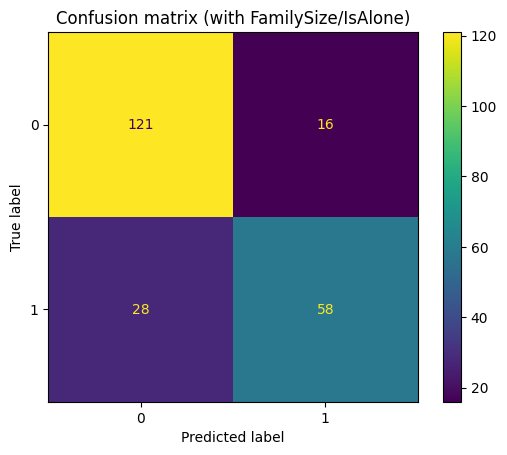

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       137
           1       0.78      0.67      0.72        86

    accuracy                           0.80       223
   macro avg       0.80      0.78      0.79       223
weighted avg       0.80      0.80      0.80       223



* You may see a small improvement, no change, or even a drop.

* Important thing is this is the first time in this lab that we are changing something to the data.

* We change it because it becomes easier to understand when we see new data generated.

* We are not optimising the model yet.


## 8. DP5 – Validate (Leakage + Stability Check)

Run the same experiment across a few random seeds and report the accuracy range.

Scores: [0.7892, 0.8341, 0.8251, 0.87, 0.8117]
Mean: 0.826
Range: (0.7892, 0.87)


If accuracy varies a lot across splits, this may mean: small dataset, noisy signal, or high variance model behaviour.



## 9. Optional: View the tree!

We keep the tree shallow to make rules visible.


* pipe2: full preprocessing + model pipeline
* pre: preprocessing step
* tree: trained decision tree
* ohe: trained one-hot encoder
* feature names: reconstructed for interpretation

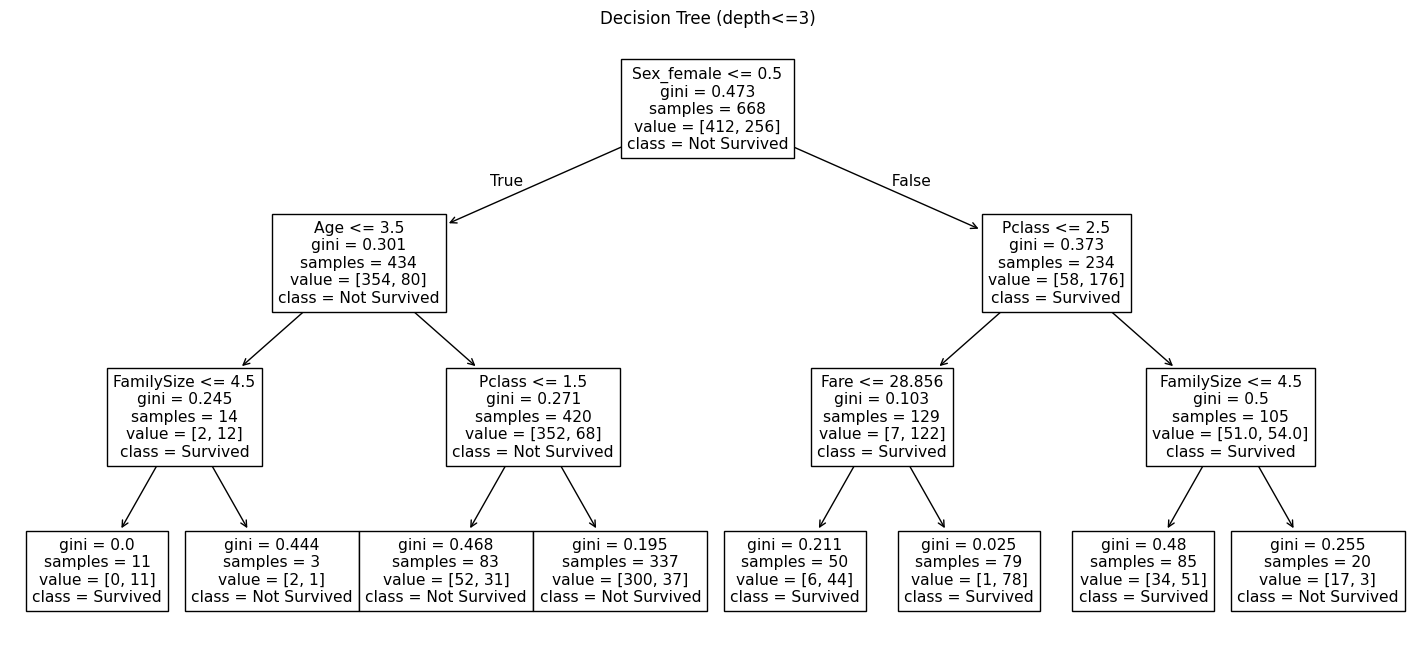


Important point is to always **Split first:** If you compute imputations/encodings on all data, you leak information from test into train and inflate the metric.

For example, when imputing `Age` using the mean/median computed from the full dataset (train+test) before splitting, you are leaking information from the test data into the train data.